In this tutorial, we are going to see the spatiotemporal mapping of regulatory networks for oligodendrocyte differentiation in the `P22 mouse brain` with the GRNs inferred by STARNet.

SpaTrack was utilized in this part of analysis.

Shen, X., Zuo, L., Ye, Z., Yuan, Z., Huang, K., Li, Z., ... & Qin, P. (2025). Inferring cell trajectories of spatial transcriptomics via optimal transport analysis. Cell Systems, 16(2). https://doi.org/10.1016/j.cels.2025.101194

To run this spatial trajectory analysis, please install a new conda env by the following command.

```bash
conda create -n spaTrack python=3.9 -y
conda activate spaTrack

pip install omicverse ipykernel
pip install spaTrack
pip install scvelo
```

In [10]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
import spaTrack as spt

import omicverse as ov
import os

import matplotlib as mpl
import scvelo as scv
from matplotlib.gridspec import GridSpec

from typing import Optional
from anndata import AnnData
from pygam import LinearGAM, s
from matplotlib.axes import Axes

import warnings
warnings.filterwarnings("ignore")

def rotate_points_90_degrees_counterclockwise(points):
    rotated_points = np.array([-points[:, 1], points[:, 0]]).T
    return rotated_points

### Import Data

Here, we load the inferred P22 mouse brain’s spatial RNA-seq data and the GRN module. (Or, you can just load your trained data)

In [25]:
adata_rna = sc.read_h5ad('Drive/Datasets/P22_Mouse/Process_Data/adata_rna_trained.h5ad')
adata_rna.uns['grn'] = {}
adata_rna.uns['grn']['adata_nlog10_pval'] = sc.read_h5ad("Drive/Datasets/P22_Mouse/Process_Data/p22-mouse_grn_nlog10_pval.adata").T
adata_rna

AnnData object with n_obs × n_vars = 9215 × 15414
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_embedding', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pre_clusters_colors', 'umap', 'grn'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'cell_embedding'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Then, we assign annotations to each region in the spatial transcriptomics data and visualize them.

[<Axes: title={'center': 'spatial domain'}, xlabel='spatial1', ylabel='spatial2'>]

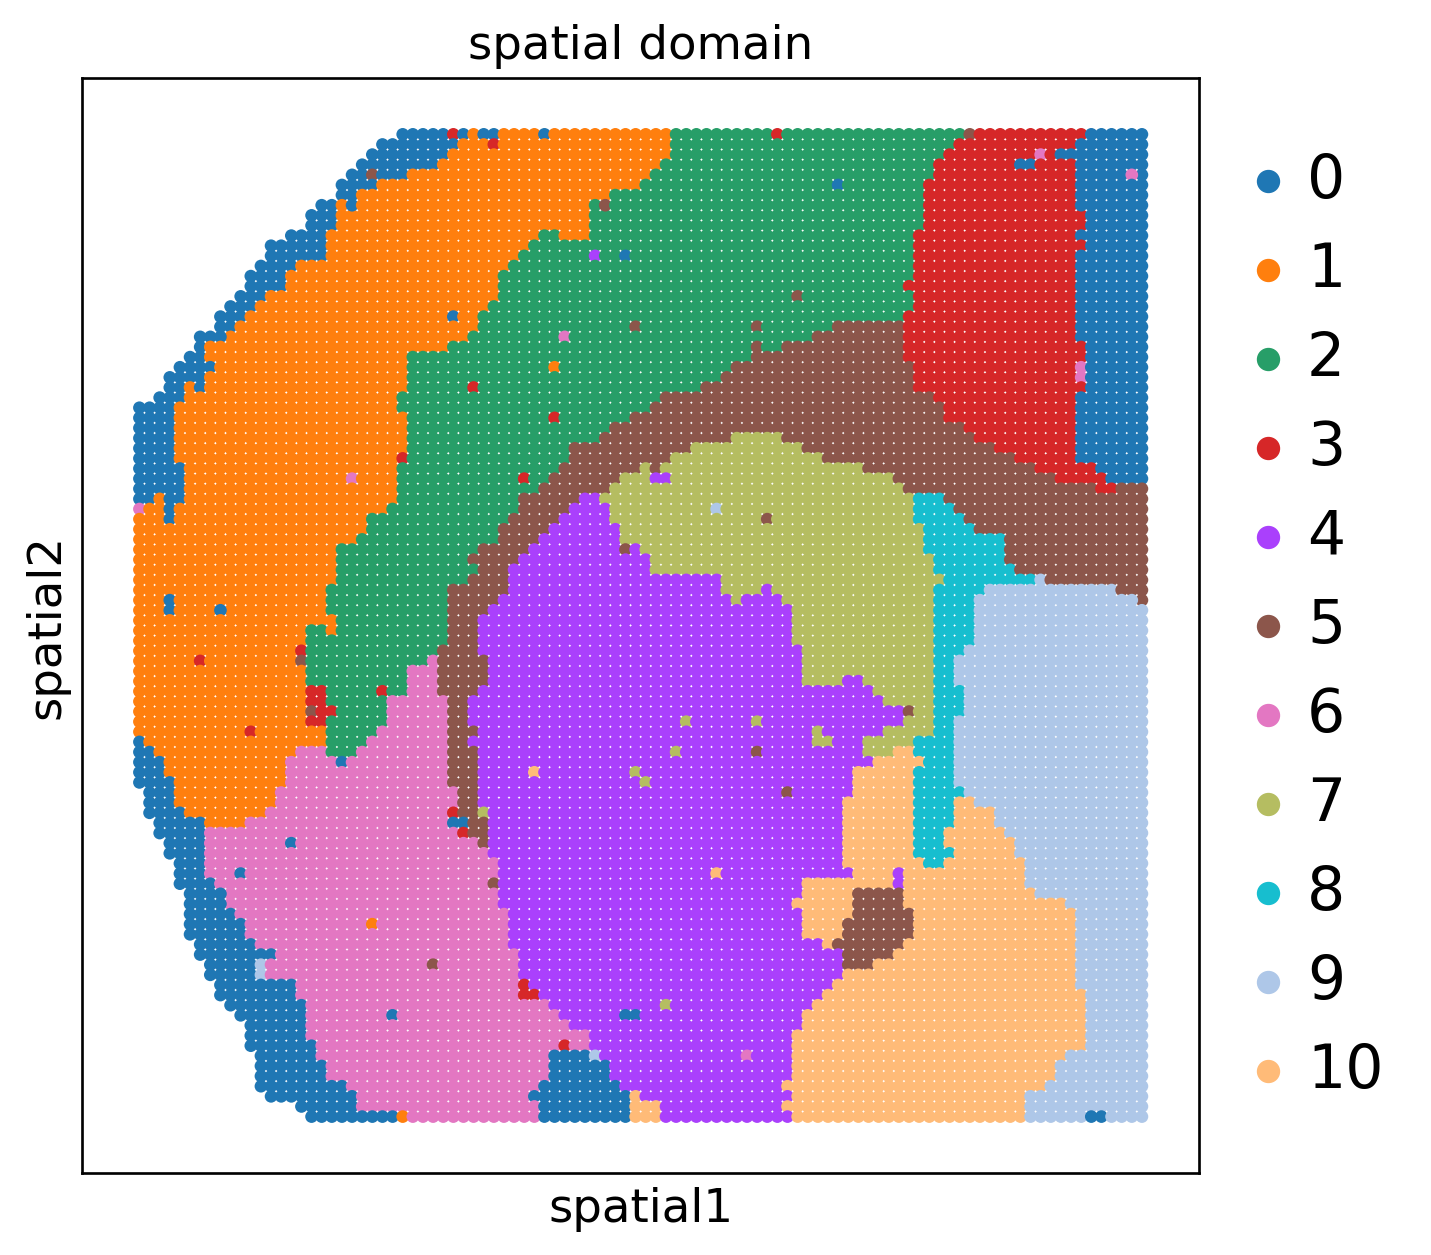

In [26]:
adata_rna.obs['spatial domain'] = adata_rna.obs['leiden'].astype('category')
adata_rna.obs['cluster'] = adata_rna.obs['spatial domain']

fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata_rna, color='spatial domain', spot_size=1.25, 
			  legend_fontsize=18, ax=ax, show=False, frameon=None)

### Pseudotime Inference via spaTrack

SpaTrack’s `assess_start_cluster` function was used to infer the beginning region of the cell differentiation by the entropy calculation. High entropy indicates a high ability to differentiate into a specific cell type. After the differentiation, the cell becomes stable and entropy decreases.

In [27]:
# Infer the start cluster by the entropy of the spatial domain
adata_rna.X = adata_rna.X.toarray()
adata_rna = spt.assess_start_cluster(adata_rna)

Cluster order sorted by entropy value:  ['8', '3', '7', '10', '5', '2', '6', '4', '9', '1', '0']


As we mainly focus on how the CCG region differentiated from the VL region, we extract this part of the data for further analysis.

In [28]:
# Extract the VL and CCG regions
# 8 is VL region and 5 is CCG region
adata_rna = adata_rna[adata_rna.obs['leiden'].isin(['5', '8'])].copy() 
adata_rna.obsm['X_spatial'] = rotate_points_90_degrees_counterclockwise(adata_rna.obsm['X_spatial'])
adata_rna.obsm['X_spatial'] = rotate_points_90_degrees_counterclockwise(adata_rna.obsm['X_spatial'])

Following the spaTrack tutorial, we designated the VL region as the starting point because it shows the highest differentiation potential. We then calculated the transition matrix using the optimal transition algorithm. From this matrix, we derived the pseudotime for each spot. Using the `spt.get_velocity()` function, we determined both velocity and direction for each spot. The parameter `n_neigh_pos=50` indicates that we incorporated pseudotime information from the 50 neighboring spots.

In [29]:
start_cells=spt.set_start_cells(adata_rna,select_way='cell_type',cell_type='8')

adata_rna.obsp["trans"] = spt.get_ot_matrix(adata_rna, data_type="spatial",alpha1=0.6,alpha2=0.4)

adata_rna.obs["ptime"] = spt.get_ptime(adata_rna, start_cells)

adata_rna.uns["E_grid"], adata_rna.uns["V_grid"] = spt.get_velocity(adata_rna, basis="spatial", n_neigh_pos=50)

alpha1(gene expression): 0.6   alpha2(spatial information): 0.4


The velocity of cells store in 'velocity_spatial'.


Then we can visualize the calculation result of differentiation

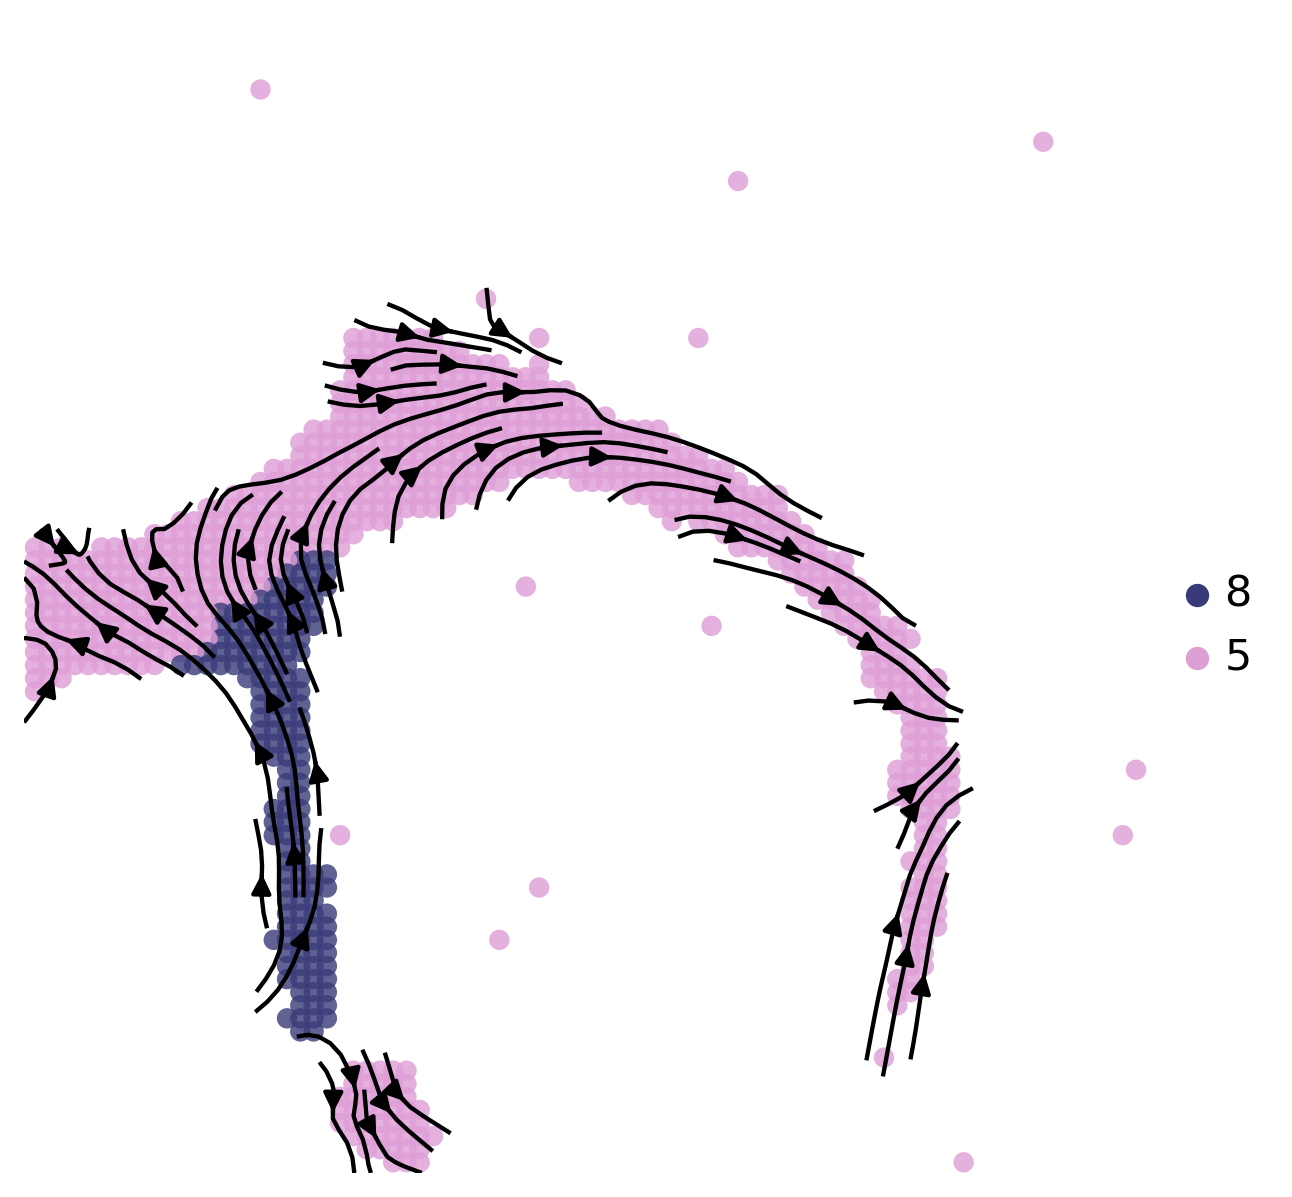

In [30]:
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(6,6))
ax = sc.pl.embedding(adata_rna,  basis='spatial',show=False,title=' ',color='cluster',ax=axs,frameon=False,palette='tab20b',legend_fontweight='normal',alpha=0.8,size=150)
ax.streamplot(adata_rna.uns['E_grid'][0], adata_rna.uns['E_grid'][1], adata_rna.uns['V_grid'][0], adata_rna.uns['V_grid'][1],density=2.3,color='black',linewidth=1.3,arrowsize=1.2)

Now, we use the General Additive Model to identify the non-linear relationship between gene expression and pseudotime. We then filter genes with fitness scores greater than 0.05 and FDR less than 0.05.

In [ ]:
adata_rna.uns['gene_list_lm'] = adata_rna.var_names
adata_rna.obs['ptime'] = adata_rna.obs['ptime']

# adata_rna.X = adata_rna.X

df_res  = spt.ptime_gene_GAM(adata_rna,core_number=5)
df_sig_res = df_res.loc[(df_res['model_fit']>0.05) & (df_res['fdr']<0.05)]

We selected several important TFs and sorted these TFs by their pseudotime.

In [33]:
gene_list = [
    'Sox2', 'Pbx1', 'Zic1', 'Sox11', 'Dlx1', 'Zic4', 'Sox9', 'Sox4', 'Hsf2',
    'Pax6', 'Pou3f3', 'Tcf12', 'Nfe2l2', 'Foxp2', 'Sox8', 'Prrx1', 'Zfp282',
    'Pou2f1', 'Foxj1', 'Dlx2', 'Arx', 'Tcf7l2', 'Sox10', 'Olig1', 'E2f7',
    'Ppara', 'Olig2'
]

df_sig_res = df_res.loc[gene_list]

sort_exp_sig = spt.order_trajectory_genes(
    adata_rna,
    df_sig_res,
    cell_number=200
)

Finally selected 27 genes.


### Visualization

Then we can visualize the relationship by plotting below.

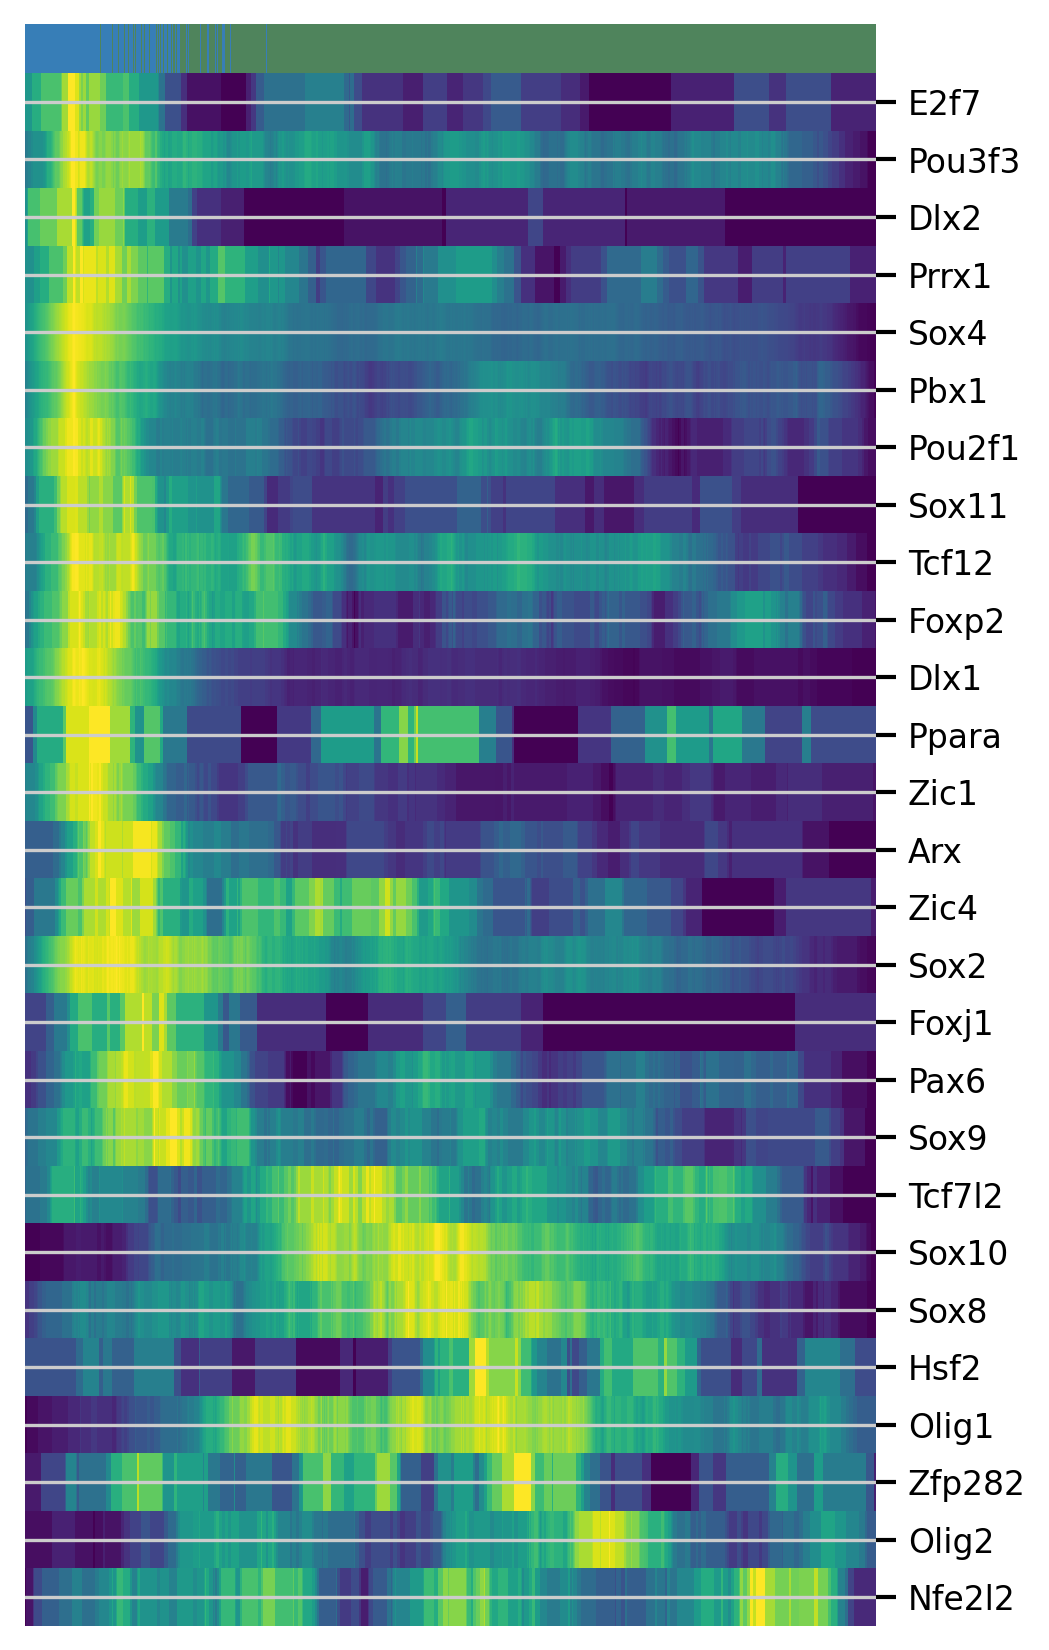

In [34]:
import scvelo as scv
adata_smooth = ad.AnnData(sort_exp_sig)
adata_smooth.uns['cluster_colors'] = ['#377EB7','#4F845C']
adata_smooth.obs['cluster'] = adata_rna[adata_smooth.obs_names,:].obs['cluster']
adata_smooth.obs['ptime'] = adata_rna[adata_smooth.obs_names,:].obs['ptime']
scv.pl.heatmap(adata_smooth, var_names=adata_smooth.var_names, sortby='ptime', 
               figsize=(4.5,7),font_scale = 0.9,
               col_color='cluster', n_convolve=100,)

Similarly, we can do the same steps for GRNs, select several important GRNs, rank them via the pseudotime, and have the visualization.

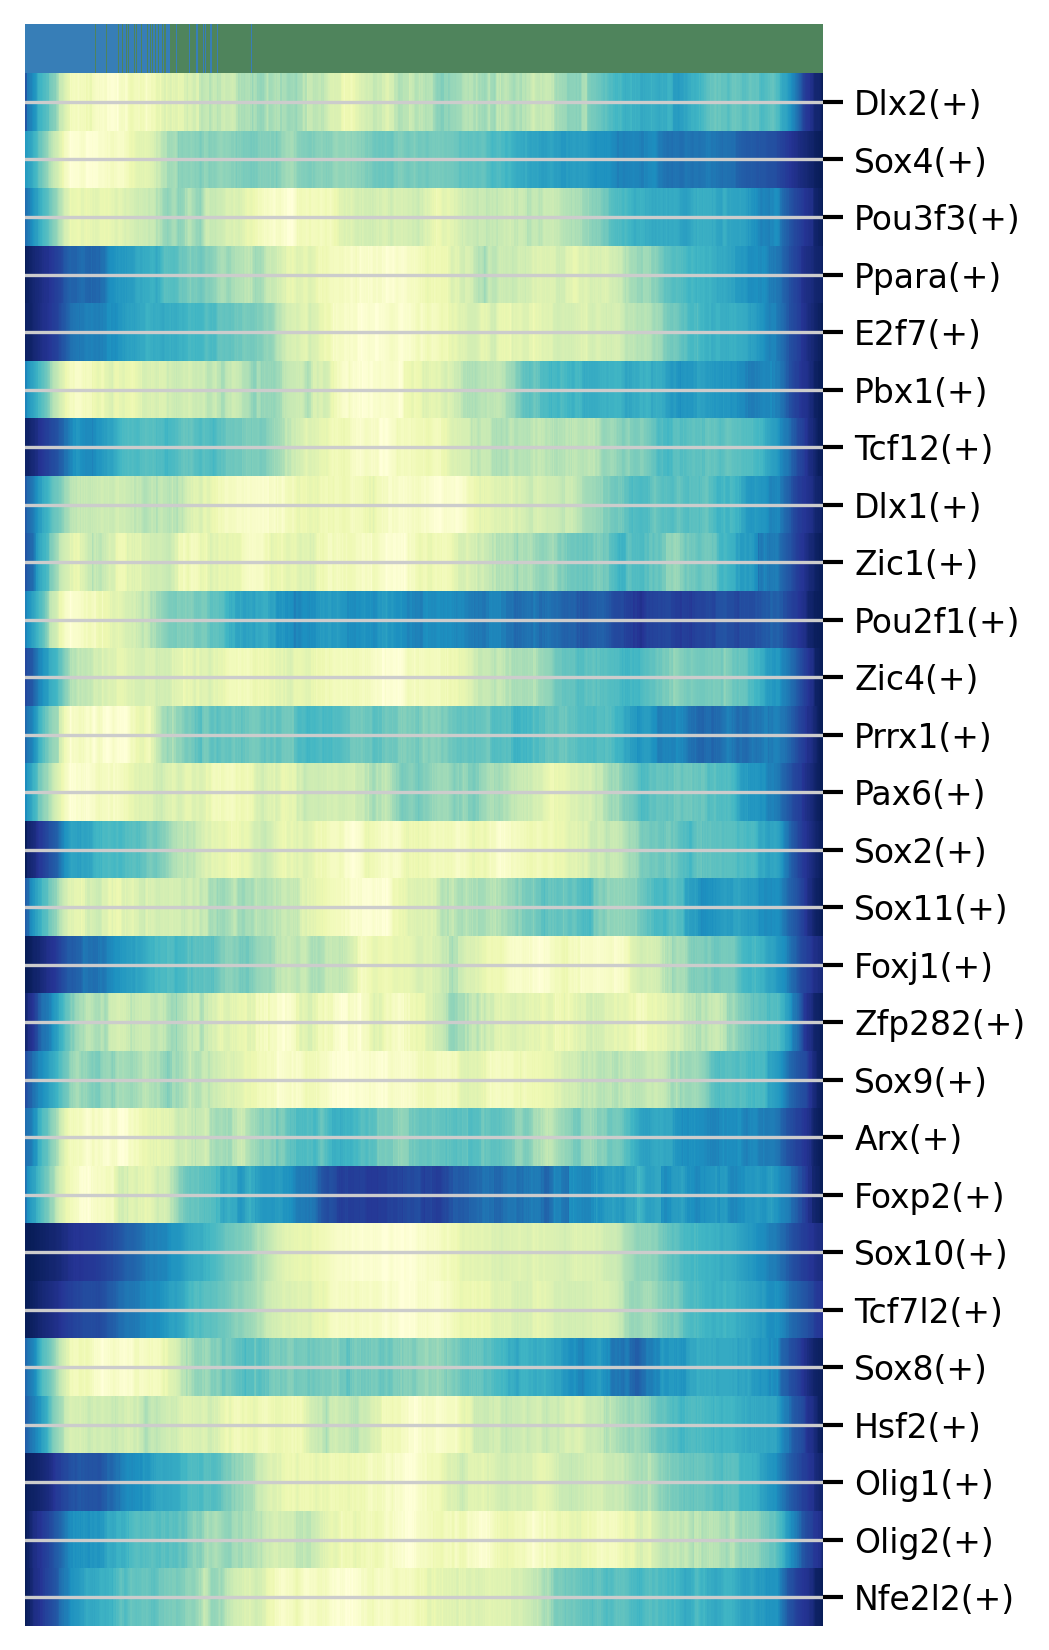

In [35]:
adata_smooth = adata_rna.uns['grn']['adata_nlog10_pval'].T[adata_rna.obs_names,gene_list]

GRN_list = ['Dlx2','Sox4','Pou3f3','Ppara','E2f7','Pbx1','Tcf12','Dlx1','Zic1','Pou2f1',
 'Zic4','Prrx1','Pax6','Sox2','Sox11','Foxj1','Zfp282','Sox9','Arx',  'Foxp2',
 'Sox10','Tcf7l2','Sox8','Hsf2','Olig1','Olig2','Nfe2l2']

adata_smooth = adata_smooth[:,GRN_list]
adata_smooth.var_names = adata_smooth.var_names + '(+)'
adata_smooth.obs['cluster'] = adata_rna[adata_smooth.obs_names,:].obs['cluster']
adata_smooth.obs['ptime'] = adata_rna[adata_smooth.obs_names,:].obs['ptime']
adata_smooth.uns['cluster_colors'] = ['#377EB7','#4F845C']
ax=scv.pl.heatmap(adata_smooth, var_names=adata_smooth.var_names, sortby='ptime', sort=False,
                  color_map='YlGnBu_r',
               figsize=(4.5,7),font_scale = 0.9,    
               col_color='cluster', n_convolve=100,)

Finally, we use the `plot_trajectory_gene()` function to visualize how specific gene expression changes across the inferred pseudotime. This visualization helps us track gene expression patterns throughout the differentiation process.

In [36]:
def plot_trajectory_gene(
    adata: AnnData,
    gene_name: str,
    line_width: int = 5,
    point_size: int = 20,
    figsize=(4, 3),
    ax: Optional[Axes] = None,
) -> Axes:
    """Plot gene expression along pseudotime trajectory."""
    
    # Prepare data
    df = pd.DataFrame({
        "ptime": adata.obs["ptime"],
        gene_name: adata[:, gene_name].X.flatten(),
    })
    
    x_ptime = df[["ptime"]].values
    y_exp = df[gene_name]

    # Create figure
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    # Remove top and right spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Fit GAM model
    gam = LinearGAM(s(0, n_splines=10))
    gam_model = gam.gridsearch(x_ptime, y_exp, progress=False)
    XX = gam_model.generate_X_grid(term=0)
    
    # Plot GAM line
    ax.plot(XX, gam_model.predict(XX), 
           color="blue",
           linewidth=line_width)

    # Configure plot
    ax.set_title(gene_name, fontsize=16, fontweight='bold')  
    ax.set_xlabel("Inferred pseudotime", fontsize=16, labelpad=2)
    ax.set_ylabel("Gene expression", fontsize=16, labelpad=2)
    
    # Configure spines and ticks
    ax.grid(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(axis='both', 
                  labelsize=16, 
                  width=1.5, 
                  length=2, 
                  pad=1)
    
    # Tight layout
    fig.tight_layout(pad=0.5)
    return ax

In [37]:
adata_rna.obs['pseudotime_box'] = ''
adata_rna.obs.loc[(adata_rna.obs['ptime']>=0)&(adata_rna.obs['ptime']<0.2),'pseudotime_box']= '0.0-0.2'
adata_rna.obs.loc[(adata_rna.obs['ptime']>=0.2)&(adata_rna.obs['ptime']<0.4),'pseudotime_box']= '0.2-0.4'
adata_rna.obs.loc[(adata_rna.obs['ptime']>=0.4)&(adata_rna.obs['ptime']<0.6),'pseudotime_box']= '0.4-0.6'
adata_rna.obs.loc[(adata_rna.obs['ptime']>=0.6)&(adata_rna.obs['ptime']<0.8),'pseudotime_box']= '0.6-0.8'
adata_rna.obs.loc[(adata_rna.obs['ptime']>=0.8)&(adata_rna.obs['ptime']<=1),'pseudotime_box']= '0.8-1.0'
adata_rna.obs['pseudotime_box'] = adata_rna.obs['pseudotime_box'].astype('category')
adata_rna

AnnData object with n_obs × n_vars = 872 × 15414
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'pre_clusters', 'spatial domain', 'cluster', 'entropy', 'tran', 'ptime', 'pseudotime_box'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_embedding', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pre_clusters_colors', 'umap', 'grn', 'spatial domain_colors', 'entropy value', 'entropy value order', 'P_grid', 'V_grid', 'E_grid',

<Axes: title={'center': 'Sox10'}, xlabel='Inferred pseudotime', ylabel='Gene expression'>

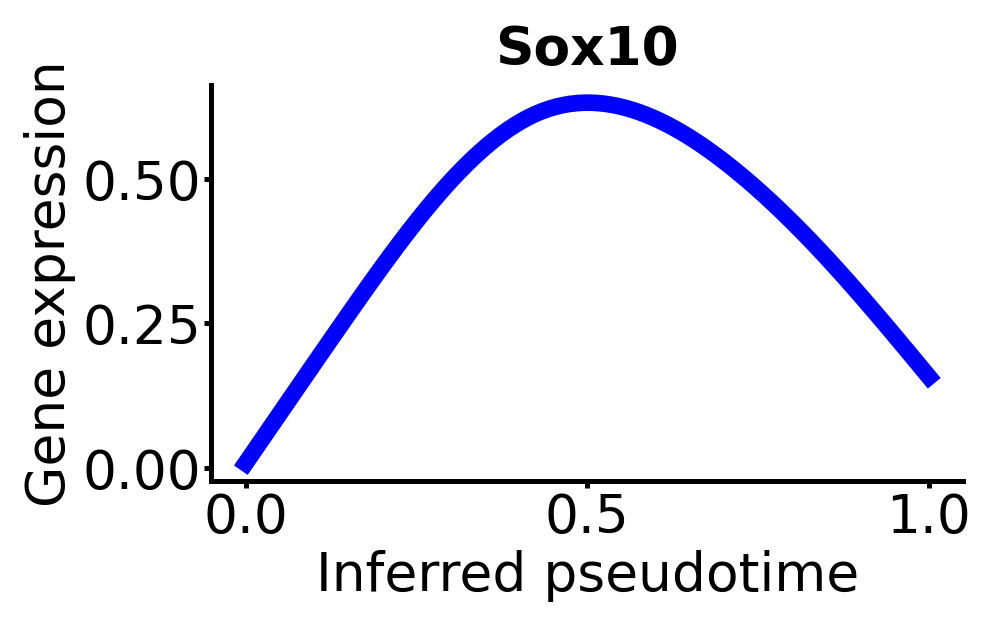

In [38]:
plot_trajectory_gene(adata_rna,gene_name='Sox10',figsize=(4,2.6))

<Axes: title={'center': 'Cldn11'}, xlabel='Inferred pseudotime', ylabel='Gene expression'>

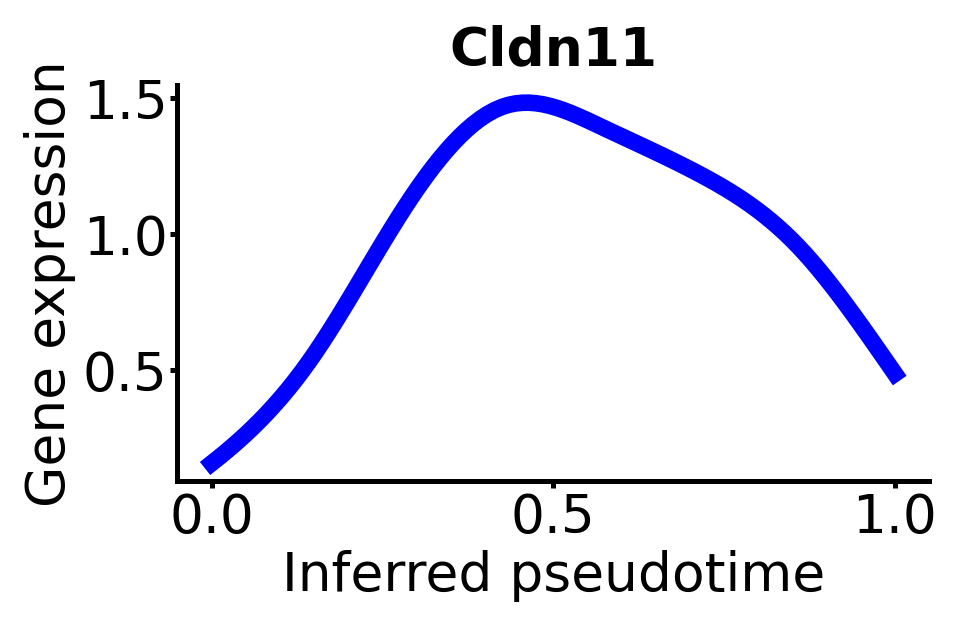

In [39]:
plot_trajectory_gene(adata_rna,gene_name='Cldn11',figsize=(4,2.6))